In [59]:
import pandas as pd
import numpy as np
import torch

import matplotlib.pyplot as plt
%matplotlib inline

import random
from PIL import Image
random.seed(50)

In [2]:
data = pd.read_csv("/home/fractaluser/Downloads/kaggle/train_ship_segmentations.csv")
data.head()

ImageId                                      EncodedPixels
0  00003e153.jpg                                                NaN
1  000155de5.jpg  264661 17 265429 33 266197 33 266965 33 267733...
2  00021ddc3.jpg  101361 1 102128 3 102896 4 103663 6 104430 9 1...
3  00021ddc3.jpg  95225 2 95992 5 96760 7 97527 9 98294 9 99062 ...
4  00021ddc3.jpg  74444 4 75212 4 75980 4 76748 4 77517 3 78285 ...

In [3]:
data.shape

(131030, 2)

In [4]:
data["EncodedPixels"].isnull().sum() #Roughly 75000 images don't have images

75000

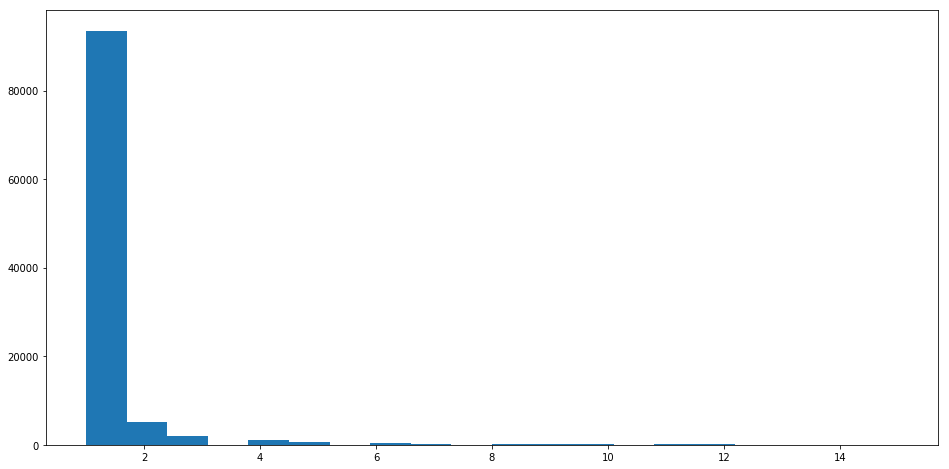

In [5]:
plt.figure(figsize=(16, 8))
plt.hist(data["ImageId"].value_counts().values, bins = 20)
plt.show()

## Semantic Segmentation

In [12]:
## rle decode
rle_decode = data[~data["EncodedPixels"].isnull()]["EncodedPixels"].values[0]
rle_decode

'264661 17 265429 33 266197 33 266965 33 267733 33 268501 33 269269 33 270037 33 270805 33 271573 33 272341 33 273109 33 273877 33 274645 33 275413 33 276181 33 276949 33 277716 34 278484 34 279252 33 280020 33 280788 33 281556 33 282324 33 283092 33 283860 33 284628 33 285396 33 286164 33 286932 33 287700 33 288468 33 289236 33 290004 33 290772 33 291540 33 292308 33 293076 33 293844 33 294612 33 295380 33 296148 33 296916 33 297684 33 298452 33 299220 33 299988 33 300756 33 301524 33 302292 33 303060 33 303827 34 304595 34 305363 33 306131 33 306899 33 307667 33 308435 33 309203 33 309971 33 310739 33 311507 33 312275 33 313043 33 313811 33 314579 33 315347 33 316115 33 316883 33 317651 33 318419 33 319187 33 319955 33 320723 33 321491 33 322259 33 323027 33 323795 33 324563 33 325331 33 326099 33 326867 33 327635 33 328403 33 329171 33 329938 34 330706 34 331474 33 332242 33 333010 33 333778 33 334546 33 335314 33 336082 33 336850 33 337618 33 338386 33 339154 33 339922 33 340690 33

In [15]:
s = rle_decode.split()

In [16]:
starts, lengths = [np.asarray(x, dtype=int) for x in (s[0:][::2], s[1:][::2])]

In [20]:
starts -=1
shape = (768, 768)
ends = starts+lengths
img = np.zeros(shape[0]*shape[1], dtype=np.uint8)
for lo, hi in zip(starts, ends):
    img[lo:hi] = 1

In [22]:
plt.imshow(img.reshape(shape).T)
plt.show()

In [24]:
semantic = data[~data["EncodedPixels"].isnull()]
semantic.head()

ImageId                                      EncodedPixels
1  000155de5.jpg  264661 17 265429 33 266197 33 266965 33 267733...
2  00021ddc3.jpg  101361 1 102128 3 102896 4 103663 6 104430 9 1...
3  00021ddc3.jpg  95225 2 95992 5 96760 7 97527 9 98294 9 99062 ...
4  00021ddc3.jpg  74444 4 75212 4 75980 4 76748 4 77517 3 78285 ...
5  00021ddc3.jpg  150423 2 151190 3 151958 3 152726 4 153495 3 1...

In [25]:
unique_semantic_images = list(semantic["ImageId"].value_counts().index)
len(unique_semantic_images)

29070

In [26]:
random.shuffle(unique_semantic_images)
split = int(0.8*(len(unique_semantic_images)))
x_train = unique_semantic_images[:split]
x_valid = unique_semantic_images[split:]
print(len(x_train), len(x_valid))

23256 5814


In [34]:
semantic_train = open("/home/fractaluser/Downloads/kaggle/semantic_train.txt", "w")
for i in x_train:
    pixels = semantic[semantic["ImageId"] == i]
    encoded = list(pixels["EncodedPixels"].values)
    encoded_all = " ".join(encoded)
    semantic_train.write("train/{} {} \n".format(i, encoded_all))
semantic_train.close()

In [35]:
semantic_valid = open("/home/fractaluser/Downloads/kaggle/semantic_valid.txt", "w")
for i in x_valid:
    pixels = semantic[semantic["ImageId"] == i]
    encoded = list(pixels["EncodedPixels"].values)
    encoded_all = " ".join(encoded)
    semantic_valid.write("train/{} {} \n".format(i, encoded_all))
semantic_valid.close()

In [37]:
with open("/home/fractaluser/Downloads/kaggle/semantic_valid.txt") as f:
    lines = f.readlines()
    num_samples = len(lines)
print(num_samples)

5814


In [38]:
for line in lines:
    break

In [51]:
line.strip().split(" ", 1)

['train/b4226486e.jpg',
 '152291 1 153058 4 153826 6 154593 9 155361 11 156128 13 156895 16 157663 18 158430 21 159199 22 159969 21 160739 18 161508 17 162278 14 163048 12 163817 10 164587 8 165356 6 166126 4 166896 1']

## Bbox analyzer. We should draw a tight horizontal bounding box on each mask and store them for yolov3.

In [91]:
def bbox2(img):
    rows = np.any(img, axis=1)
    cols = np.any(img, axis=0)
    rmin, rmax = np.where(rows)[0][[0, -1]]
    cmin, cmax = np.where(cols)[0][[0, -1]]
    return rmin, rmax, cmin, cmax

In [93]:
ymin, ymax, xmin, xmax = bbox2(img.reshape(shape).T)
print(ymin, ymax, xmin, xmax)

464 499 344 447


In [96]:
import sys
sys.path.insert(0, "../")

In [97]:
from seger.utils import rle_decode

In [104]:
boxes_train = open("/home/fractaluser/Downloads/kaggle/boxes_train.txt", "w")
for i in x_train:
    pixels = semantic[semantic["ImageId"] == i]
    encoded = list(pixels["EncodedPixels"].values)
    boxes = []
    for j in encoded:
        array = rle_decode(j, (768, 768))
        ymin, ymax, xmin, xmax = bbox2(array)
        boxes.extend([int(ymin), int(xmin), int(ymax), int(xmax), 1])
    boxes = " ".join([str(m) for m in boxes])
    boxes_train.write("train/{} {} \n".format(i, boxes))
boxes_train.close()

In [105]:
boxes_valid = open("/home/fractaluser/Downloads/kaggle/boxes_valid.txt", "w")
for i in x_valid:
    pixels = semantic[semantic["ImageId"] == i]
    encoded = list(pixels["EncodedPixels"].values)
    boxes = []
    for j in encoded:
        array = rle_decode(j, (768, 768))
        ymin, ymax, xmin, xmax = bbox2(array)
        boxes.extend([int(ymin), int(xmin), int(ymax), int(xmax), 1])
    boxes = " ".join([str(m) for m in boxes])
    boxes_valid.write("train/{} {} \n".format(i, boxes))
boxes_valid.close()

## Image classifier

In [13]:
## There are a total of 104070 images
data["ImageId"].value_counts().shape

(104070,)

In [19]:
## Imbalance in the dataset 
print(data["EncodedPixels"].isnull().sum())
print(data["ImageId"].value_counts().shape[0])
print(75000/104070)

75000
104070
0.7206687806284232


In [32]:
no_ship_list = list(data[data["EncodedPixels"].isnull()]["ImageId"].values)
ship_list = list(data[~data["EncodedPixels"].isnull()]["ImageId"].value_counts().index)
print(len(no_ship_list), len(ship_list))

75000 29070


In [33]:
outputs_0 = [0 for i in range(len(no_ship_list))] 
outputs_1 = [1 for i in range(len(ship_list))]
ship_list = no_ship_list+ship_list
outputs = outputs_0 + outputs_1
print(len(ship_list), len(outputs))

104070 104070


In [36]:
data = list(zip(ship_list, outputs))
random.shuffle(data)

In [37]:
ship_list, outputs = zip(*data)
print(len(ship_list), len(outputs))

104070 104070


In [38]:
print(ship_list[:10])

('93d36d91d.jpg', 'c654376ca.jpg', 'f2ff348a1.jpg', 'a966a7296.jpg', 'e490c0362.jpg', '797936e7f.jpg', 'f3d971c58.jpg', '25646f16e.jpg', '91bf5922a.jpg', '64d09a5b5.jpg')


In [41]:
per = int(0.8*(len(ship_list)))
x_train, y_train = ship_list[:per], outputs[:per]
x_valid, y_valid = ship_list[per:], outputs[per:]
print(len(x_train), len(y_train), len(x_valid), len(y_valid))

83256 83256 20814 20814


In [44]:
train = open("/home/fractaluser/Downloads/kaggle/x_train.txt", "w")
for i, j in zip(x_train, y_train):
    train.write("train/{} {} \n".format(i, j))
train.close()

In [45]:
valid = open("/home/fractaluser/Downloads/kaggle/x_valid.txt", "w")
for i, j in zip(x_valid, y_valid):
    valid.write("train/{} {} \n".format(i, j))
valid.close()